Carries out gene-area boundary analysis and generates figure panels for fig 1e&f and supp figure 2


In [ ]:
import numpy as np
import pandas as pd
import os
import nibabel as nb
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib_surface_plotting as msp
from scripts.prepare_gene_lists.gene_mapping import get_indices
import scripts.paths as p
from vast import surface_tools
import scipy.stats as st
from PIL import Image
import subprocess
from scipy.spatial.transform import Rotation as R
import scipy.ndimage as nd
import ptitprince as pt



In [2]:
#Load in data
base_dir = '/data1/allen_surfaces/'
cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
labels_dict = cortex.labeltable.get_labels_as_dict()
parcellation = cortex.darrays[0].data

cortex=cortex.darrays[0].data>0
concat=np.load(os.path.join(base_dir,'all_subs_smoothed_z.npy'))

grad=np.load(os.path.join(base_dir,'all_subs_gradients.npy'))
predictability = np.load('repro_estimates.npy')


In [ ]:
surf=nb.load(os.path.join(p.fs_LR32k_dir,'fs_LR.32k.L.inflated.surf.gii'))


In [ ]:
#functions to create border plots
def border_plots(roi1,roi2,genes_of_interest,parcellation,concat,grad,inv_reg_dict):
    from PIL import Image
    border_name = roi1.split('_')[1]+'_'+roi2.split('_')[1]
    if not os.path.exists(f'figures/{border_name}'):
        os.makedirs(f'figures/{border_name}')
    region_index1 = inv_reg_dict[roi1]
    region_index2 = inv_reg_dict[roi2]
    parcels = (parcellation==region_index1).astype(int) + (parcellation==region_index2).astype(int)*2
    include = np.zeros(len(genes_of_interest),dtype=bool)
    surf=nb.load(os.path.join(p.fs_LR32k_dir,'fs_LR.32k.L.very_inflated.surf.gii'))

    for ind,g in enumerate(genes_of_interest):
        try:
            gene_i,m=get_indices([g]);
            include[ind]=True
            m=concat[gene_i[0]]
            gm=grad[gene_i[0]]
            for r in [90,270]:
                msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
                              m,rotate=r,
                              base_size=20,cmap='turbo',colorbar=False,parcel=parcels,parcel_cmap={0:[1,1,1,1],1:[1,1,1,1],
                                                                                             2:[1,1,1,1]},
                              mask=~cortex,vmax=np.percentile(m[parcels>0],99),vmin=np.percentile(m[parcels>0],1),
                                filename= 'tmp.png')
                subprocess.call(f'convert tmp.png -trim figures/{border_name}/{g}_{r}_mag.png',shell=True)

            for r in [90,270]:
                msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
                          gm,rotate=r,
                              base_size=20,cmap='magma',colorbar=False,parcel=parcels,parcel_cmap={0:[1,1,1,1],1:[1,1,1,1],
                                                                                             2:[1,1,1,1]},
                          vmax=np.percentile(gm[parcels>0],99),vmin=np.percentile(gm[parcels>0],1),mask=~cortex,
                          filename= 'tmp.png'
                             )
                subprocess.call(f'convert tmp.png -trim figures/{border_name}/{g}_{r}_grad.png',shell=True)
        except ValueError:
            pass
    n_rows = np.sum(include)
    fig,axes = plt.subplots(n_rows,4,figsize=(25,n_rows*5))
    axes=axes.ravel()
    k=-1
    for g in np.array(genes_of_interest)[include]:
        for r in [90,270]:
            k+=1
            im=Image.open(f'figures/{border_name}/{g}_{r}_mag.png').convert('RGBA')
            axes[k].imshow(im)
            axes[k].axis('off')
        for r in [90,270]:
            k+=1
            im=Image.open(f'figures/{border_name}/{g}_{r}_grad.png').convert('RGBA')
            axes[k].imshow(im)
            axes[k].axis('off')
    return fig

In [ ]:
# get dictionary to invert region labels
inv_reg_dict = {v: k for k, v in labels_dict.items()}

neighbours=surface_tools.get_neighbours(os.path.join(p.fs_LR32k_dir,
                                'fs_LR.32k.L.very_inflated.surf.gii'))

In [ ]:
#identify boundary vertices
def get_boundary(roi1,roi2,neighbours,parcellation,regional_dictionary):
    region_index1 = inv_reg_dict[roi1]
    region_index2 = inv_reg_dict[roi2]
    r1 = neighbours[parcellation==region_index1]
    r2 = neighbours[parcellation==region_index2]
    mv = []
    for v in r1:
        mv.extend(v)
    sv = []
    for v in r2:
        sv.extend(v)
    mv = np.unique(mv)
    sv = np.unique(sv)
    overlap = np.intersect1d(mv,np.where(parcellation==region_index2))
    overlap2=np.intersect1d(sv,np.where(parcellation==region_index1))
    border = np.hstack([overlap,overlap2])
    return border

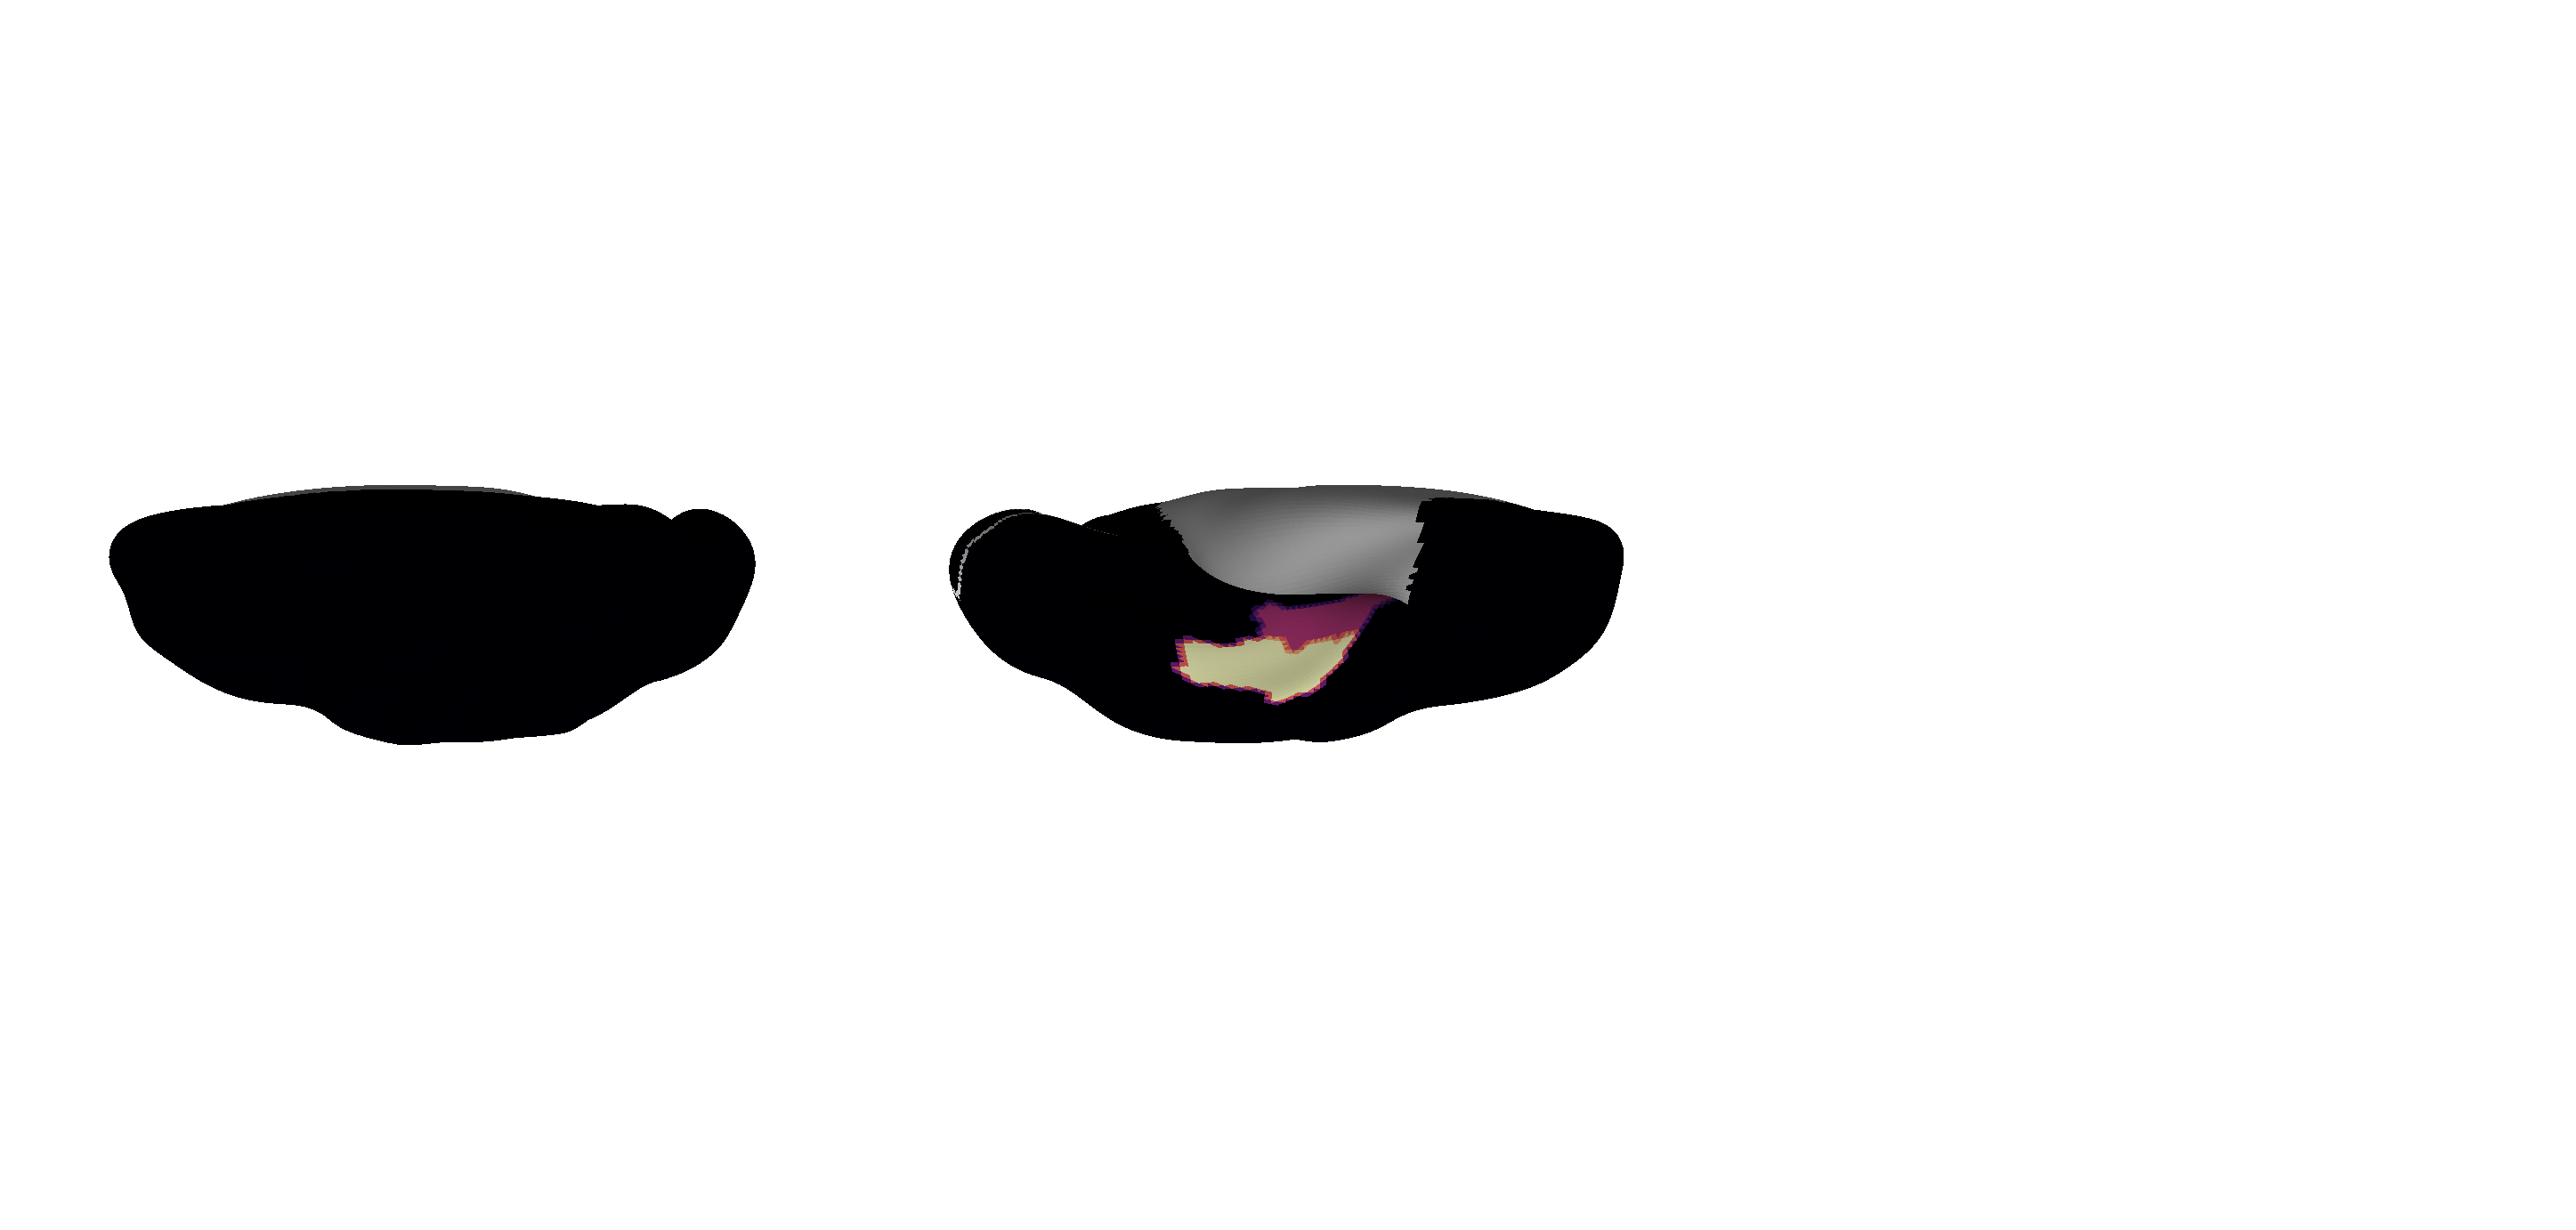

In [ ]:
#isolate two rois of interest
rois = (parcellation==inv_reg_dict['L_PeEc_ROI']).astype(int)
rois += (parcellation==inv_reg_dict['L_TF_ROI']).astype(int)*2
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
                  rois,z_rotate=90,
                      base_size=20,cmap='magma',colorbar=False,parcel=v1,parcel_cmap={0:[1,1,1,1],1:[1,1,1,1]},
                  vmax=2,vmin=0,mask=~cortex,
                  filename= 'tmp.png'
                     )

In [ ]:
#get medial temporal border
mtl_border = get_boundary('L_PeEc_ROI','L_TF_ROI',neighbours,parcellation,inv_reg_dict)


In [ ]:
def ranked_ttest(roi1,roi2,concat,parcellation,inv_reg_dict):
    region_index1 = inv_reg_dict[roi1]
    region_index2 = inv_reg_dict[roi2]
    tstats=st.ttest_ind(concat[:,parcellation==region_index1],concat[:,parcellation==region_index2],axis=1)[0]
    return tstats

def generate_ranked_table(gene_names,border_stats,tstats, predictability):
    df = pd.DataFrame(np.vstack([gene_names,tstats,
                             border_stats,predictability]).T,
                      columns = ['Genes','Ttest','Border','Predictability'])
    #df['Combined_rank'] = ((df['Ttest'].argsort().argsort()+df['Border'].argsort().argsort()).argsort().argsort())/(2*len(df))
    df['Ttest_rank'] = df['Ttest'].argsort().argsort()/len(df)
    df['Border_rank'] = df['Border'].argsort().argsort()/len(df)
    return df

def get_table_from_rois(roi1,roi2,neighbours, parcellation, 
                        inv_reg_dict, concat, grad,gene_names,
                        predictability
                       ):
    border = get_boundary(roi1,roi2,neighbours,parcellation,inv_reg_dict)
    tstats = ranked_ttest(roi1,roi2,
                         concat,parcellation,inv_reg_dict)
    border_stats = grad[:,border].mean(axis=1)
    df = generate_ranked_table(gene_names,border_stats,tstats, predictability)
    return df

In [ ]:
gene_names=np.loadtxt('weighted_island_vectors/gene_names.txt',dtype=str)

roi_pairs = {'V1 V2':['L_V1_ROI','L_V2_ROI'],
            '44 45':['L_44_ROI','L_45_ROI']}
bvals=[]
tvals = [] 
source=[]
rp=[]
gene_lists = {'Human:\nV1 V2' :['SYT6','TLE4','PCP4','PENK'],
                  'Macaque:\nV1 V2' : ['OSTN', 'PHACTR2', 'KCNH8', 'ADAMTS17'],
                    
                    'Macaque:\n44 45b' :['SCN1B', 'KCNS1', 'TRIM55', 'RING1'],
                 }

for ri,roi_pair in enumerate(roi_pairs.keys()):
    df =get_table_from_rois(roi_pairs[roi_pair][0],roi_pairs[roi_pair][1],neighbours, parcellation, 
                            inv_reg_dict, concat, grad,gene_names,
                            predictability
                           )
    for i,gl in enumerate(gene_lists.keys()):
        gene_indices,_ = get_indices(gene_lists[gl])
        df['Border_rank'][gene_indices].values
        for g in gene_lists[gl]:
            if (ri==0 and i<2) or (ri==1 and i==2):
                try:
                    gene_i,_=get_indices([g])
                    bvals.append(df['Border_rank'][gene_i].values[0])
                    tvals.append(df['Ttest_rank'][gene_i].values[0])
                    source.append(gl)
                    rp.append(roi_pair)
                except ValueError:
                    pass


matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...


In [ ]:
scores=np.zeros(3)
stored_scores=[]
string_genes = []
for i,gl in enumerate(gene_lists.keys()):
    gene_indices,mask = get_indices(gene_lists[gl])
    if 'V1' in gl:
        roi_pair='V1 V2'
    else:
        roi_pair='44 45'
    df =get_table_from_rois(roi_pairs[roi_pair][0],roi_pairs[roi_pair][1],neighbours, parcellation, 
                            inv_reg_dict, concat, grad,gene_names,
                            predictability
                           )
    scores[i] = np.median(df['Border_rank'][gene_indices].values)*100
    stored_scores.append(df['Border_rank'][gene_indices].values*100)
    gs=np.array(gene_lists[gl])[mask]
    string=', '.join(gs)
    if i==1:
        string1=', '.join(gs[:2])
        string2=', '.join(gs[2:])
        string = string1+',\n'+string2
    string_genes.append(string)
    
    

matching gene ids and names...
matching gene ids and names...
matching gene ids and names...


In [13]:
n_perm=10000
null_dists = np.zeros((n_perm,2))
for perm in np.arange(n_perm):
    vals = np.random.choice(df['Border_rank'].values,4)
    null_dists[perm,0] = np.median(vals)*100
    null_dists[perm,1] = np.median(vals[:3])*100


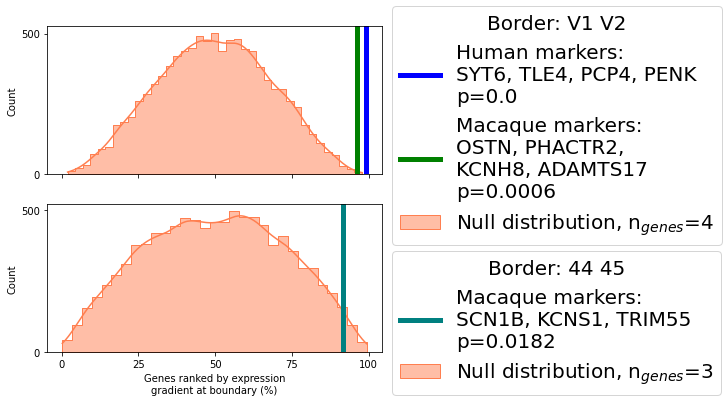

In [ ]:
fig,axes = plt.subplots(2,1,figsize=(6,6),sharex=True)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

sns.histplot(null_dists[:,0],
            kde=True,element="step",
            ax=axes[0],color='coral',label='Null distribution, n$_{genes}$=4')
sns.histplot(null_dists[:,1],
            kde=True,element="step",
            ax=axes[1],color='coral',label='Null distribution, n$_{genes}$=3')
#sns.kdeplot(stored_scores[0],color='blue',
#           ax=axes[0])
axes[0].axvline(scores[0],color='blue',lw=5,
                label=f'Human markers:\n{string_genes[0]}\np={np.mean(scores[0]<null_dists[:,0])}')
axes[0].axvline(scores[1],color='green',lw=5,
                label=f'Macaque markers:\n{string_genes[1]}\np={np.mean(scores[1]<null_dists[:,0])}')
axes[1].axvline(scores[2],color='teal',lw=5,
                label=f'Macaque markers:\n{string_genes[2]}\np={np.mean(scores[2]<null_dists[:,1])}')
axes[0].legend(title='Border: V1 V2',
               bbox_to_anchor=(1, 1.2),
      )
axes[0].set_yticks([0,500])
axes[1].legend(title='Border: 44 45',
               bbox_to_anchor=(1, .75),)
axes[1].set_yticks([0,500])


axes[1].set_xlabel('Genes ranked by expression\ngradient at boundary (%)')
#axes[0].set_yticks([0,250,500]);
#axes[1].set_yticks([0,250,500]);

fig.savefig('figures/boundary_histograms_all.pdf')

scores

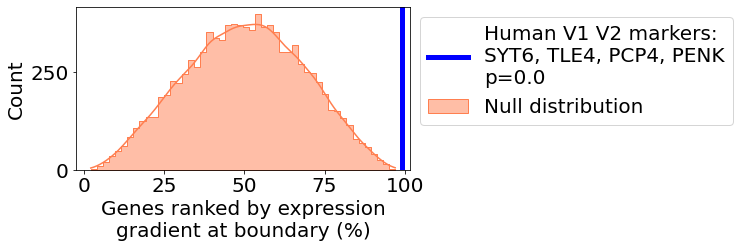

In [15]:
n_perm=10000
null_dists = np.zeros((n_perm,2))
for perm in np.arange(n_perm):
    vals = np.random.choice(df['Border_rank'].values,4)
    null_dists[perm,0] = np.median(vals)*100
    null_dists[perm,1] = np.median(vals[:3])*100

fig,axes = plt.subplots(1,1,figsize=(6,3),sharex=True)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

sns.histplot(null_dists[:,0],
            kde=True,element="step",
            ax=axes,color='coral',label='Null distribution',
            bins=50)

axes.axvline(scores[0],color='blue',lw=5,
       label=f'Human V1 V2 markers:\n{string_genes[0]}\np={np.mean(scores[0]<null_dists[:,0])}')
axes.legend( #title='Border: V1 V2',
               bbox_to_anchor=(1, 1.),
      )

axes.set_xlabel('Genes ranked by expression\ngradient at boundary (%)')
axes.set_yticks([0,250]);

fig.savefig('figures/boundary_histograms.pdf')


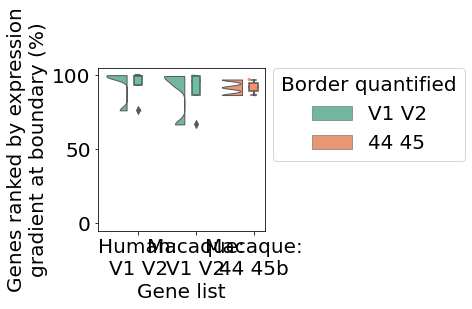

In [16]:
import ptitprince as pt
label='Genes ranked by expression\ngradient at boundary (%)'
plot_df = pd.DataFrame(np.vstack([rp,source,bvals]).T,
                       columns=['Border quantified','Gene list',
                       label])
plot_df[label]=plot_df[label].astype(float)*100
fig, ax = plt.subplots(1,figsize=(3,3))
pt.RainCloud(data = plot_df, x='Gene list',
             y=label,
             hue='Border quantified',ax=ax
            )
ax.set_xlim(-0.7,2.2),
ax.set_ylim([-5,105])
fig.savefig('figures/boundary_genes_raincloud.pdf')

In [17]:
def rank_sign_borders(df):
    df['Border_signed'] = df['Border'].astype(float)
    df['Border_signed'][df['Ttest'].astype(float)<0] = -df['Border_signed'][df['Ttest'].astype(float)<0]
    return df

In [18]:
#list of available ish genes
ish_genes=np.loadtxt('ish_gene_lists/ish_genes.txt',dtype=str)



In [20]:
#filter down ranked genes to just ish genes
df =get_table_from_rois('L_V1_ROI','L_V2_ROI',neighbours, parcellation, 
                            inv_reg_dict, concat, grad,gene_names,
                            predictability
                           )
filtered = []
df = rank_sign_borders(df)
df_sorted=df.sort_values('Border_signed')
df_sorted['Filter_genes']=0
for g in df_sorted.iterrows():
    if g[1]['Genes'] in ish_genes:
        filtered.append(g[1])
        df_sorted['Filter_genes'][g[0]]=1


df_ish=pd.DataFrame(filtered)
df_ish

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Genes       Ttest       Border      Predictability  Ttest_rank  \
394    ADRA1B  -24.447392   0.10277774  0.9484194376890684    0.333141   
7777    HTR2C   -21.39238  0.089853816  0.9688749694753468    0.309080   
6998    GRIA3  -19.036442  0.088870056   0.756271989621885    0.248111   
3856     CRYM  -22.184381   0.08638204  0.8849670186025755    0.316780   
6365   GABRA3   -21.05023   0.08515308  0.9678190335679582    0.305134   
...       ...         ...          ...                 ...         ...   
7771    HTR1B   25.611898   0.10915401  0.7031082033461824    0.809297   
3254    CHRM2   18.919827   0.11753562  0.9306989068132965    0.745729   
396    ADRA2A   19.621231   0.12776975  0.7490291767943418    0.751504   
7027     GRM4   21.649265    0.1303277  0.8534483454126401    0.794909   
17683    SYT6   29.361853   0.16072744  0.9547403399333129    0.818296   

       Border_rank  Border_signed  Filter_genes  
394       0.995621      -0.102778             0  
7777      0.990713      -0.089854             0  
6998      0.990231      -0.088870             0  
3856      0.988836      -0.086382             0  
6365      0.988210      -0.085153             0  
...            ...            ...           ...  
7771      0.996920       0.109154             0  
3254      0.998123       0.117536             0  
396       0.998845       0.127770             0  
7027      0.998941       0.130328             0  
17683     0.999808       0.160727             0  

[166 rows x 8 columns]

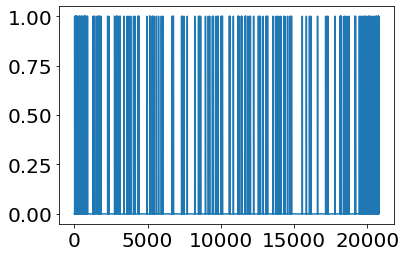

In [22]:
#check if ish genes are available across the distribution of boundary ranks
plt.plot(nd.gaussian_filter1d(df_sorted['Filter_genes'].values.astype(float),0.1))

In [24]:
#gene: study number, section number (0 indexing)
#storing sections for downloading from Allen to be quality checked
slice_dict = {'ADRA1B':[182871291,1],
              'HTR2C':[80502157,0],
              'GABRA3':[80669091,0],
              'GRM3':[80501984,1],
              'ADCYAP1':[182875722,1],
              'GRM1':[80501483,1],
             'GRIK2':[183131128,2],
             'HTR1A':[80502072,1],
              
              'ADORA2A':[80499160,3],
              'SLC38A5':[183130308,1],
             'AANAT':[80457972,0],
              'HTR2A':[80502133,0],
              'GRIN2A':[80643460,3],
             'GABRG3':[80669124,1],
              'GRM4':[80502002, 1],
             'SYT6':[182876358,0]}

slice_dict = {'ADRA1B':[182871291,1],
              'HTR2C':[80502157,0],
              'GRM4':[80502002, 1],
              'SYT6':[182876358,0]
             }


In [25]:

df =get_table_from_rois('L_PeEc_ROI','L_TF_ROI',neighbours, parcellation, 
                            inv_reg_dict, concat, grad,gene_names,
                            predictability
                           )
filtered = []
df = rank_sign_borders(df)
df_sorted=df.sort_values('Border_signed')
df_sorted['Filter_genes']=0
for g in df_sorted.iterrows():
    if g[1]['Genes'] in ish_genes:
        filtered.append(g[1])
        df_sorted['Filter_genes'][g[0]]=1


df_ish=pd.DataFrame(filtered)
df_ish

/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/kwagstyl/anaconda3/envs/lexicon/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.


Empty DataFrame
Columns: []
Index: []

In [27]:
slice_dict = {#DRD1 not sampled in parahippocampal
    'HTR2A':[158043898,1],
    'NGB':[158036965,0],
              
              
              
              #'CHRNA3':[158045059,]
    'NTS':[158042999, 0],
             }


In [28]:
#get ROI and all neigbouring ROIs,
#crop them out of spherical coords. ?Rotate to be on the equator + flatten
#plot and rescale
def get_rois_and_neighbours(roi1,roi2,inv_reg_dict,neighbours,parcellation):
    """mask for rois and neighbours"""
    region_index1 = inv_reg_dict[roi1]
    region_index2 = inv_reg_dict[roi2]
    n1=neighbours[parcellation==region_index1]
    n2= neighbours[parcellation==region_index2]
    restricted_parcels = (parcellation==region_index1).astype(int)+(parcellation==region_index2).astype(int)*2
    verts=[]
    for n in [n1,n2]:
        for v in n:
            verts.extend(v)
    rois = np.unique(parcellation[np.unique(verts)])
    mask = np.zeros(len(parcellation), dtype=bool)
    for r in rois:
        if r>0:
            mask[parcellation==r]=1
    return mask, restricted_parcels

def flatten(roi_mask,d=np.pi/5,rotate_extra=None):
    import vast.surface_tools as vst
    from scipy.spatial.transform import Rotation as R
    sphere_surf = nb.load('/data1/allen_surfaces/hcp_surfs/fs_LR32k/fs_LR.32k.L.sphere.surf.gii')
    coords = sphere_surf.darrays[0].data
    roi_com = coords[roi_mask]
    #st.spherical_np(np.mean(roi_com, axis=0).reshape(-1,1))
    spherical_com = vst.spherical_np(np.mean(roi_com, axis=0).reshape(-1,1).T)
    rotation1=spherical_com[0,2]
    rotation2=spherical_com[0,1]
    r = R.from_euler('zy', [-rotation1, np.pi/2-rotation2], degrees=False)

    rotated_coords = r.apply(coords)
    if rotate_extra is not None:
        r = R.from_euler('x', [rotate_extra], degrees=True)
        rotated_coords = r.apply(rotated_coords)
    spherical_rotated_latitude = vst.spherical_np(rotated_coords)
    flat_coords = np.zeros_like(spherical_rotated_latitude)
    flat_coords[:,0] = spherical_rotated_latitude[:,1]-np.pi/2
    flat_coords[:,1] = spherical_rotated_latitude[:,2]
    plot_mask = np.logical_and( np.logical_and(flat_coords[:,0]>-d,
                              flat_coords[:,0]<d,
                              ),
                               np.logical_and(flat_coords[:,1]>-d,
                              flat_coords[:,1]<d,
                              ))
    flat_coords[~plot_mask]=np.mean(flat_coords,axis=0)
    faces = sphere_surf.darrays[1].data
    new_faces = faces[plot_mask[faces].all(axis=1)]
    return flat_coords,new_faces,plot_mask

def plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='turbo',mask=None):
    
    msp.plot_surf(flat_coords,new_faces,m,
              cmap=cmap, vmin=np.percentile(m[restricted_parcels>0],10),
              vmax=np.percentile(m[restricted_parcels>0],90),
                 flat_map=True,
                  colorbar=False,
             parcel=restricted_parcels,
            parcel_cmap={0:[1,1,1,1],1:[1,1,1,1],
                   2:[1,1,1,1],},
              neighbours=neighbours,
              base_size=40,mask=mask,
              filename='tmp.png'
             )
    plt.close('all')
    subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
    im_arr = np.array(Image.open('tmp2.png').convert('RGBA').rotate(270))
    return im_arr

matching gene ids and names...


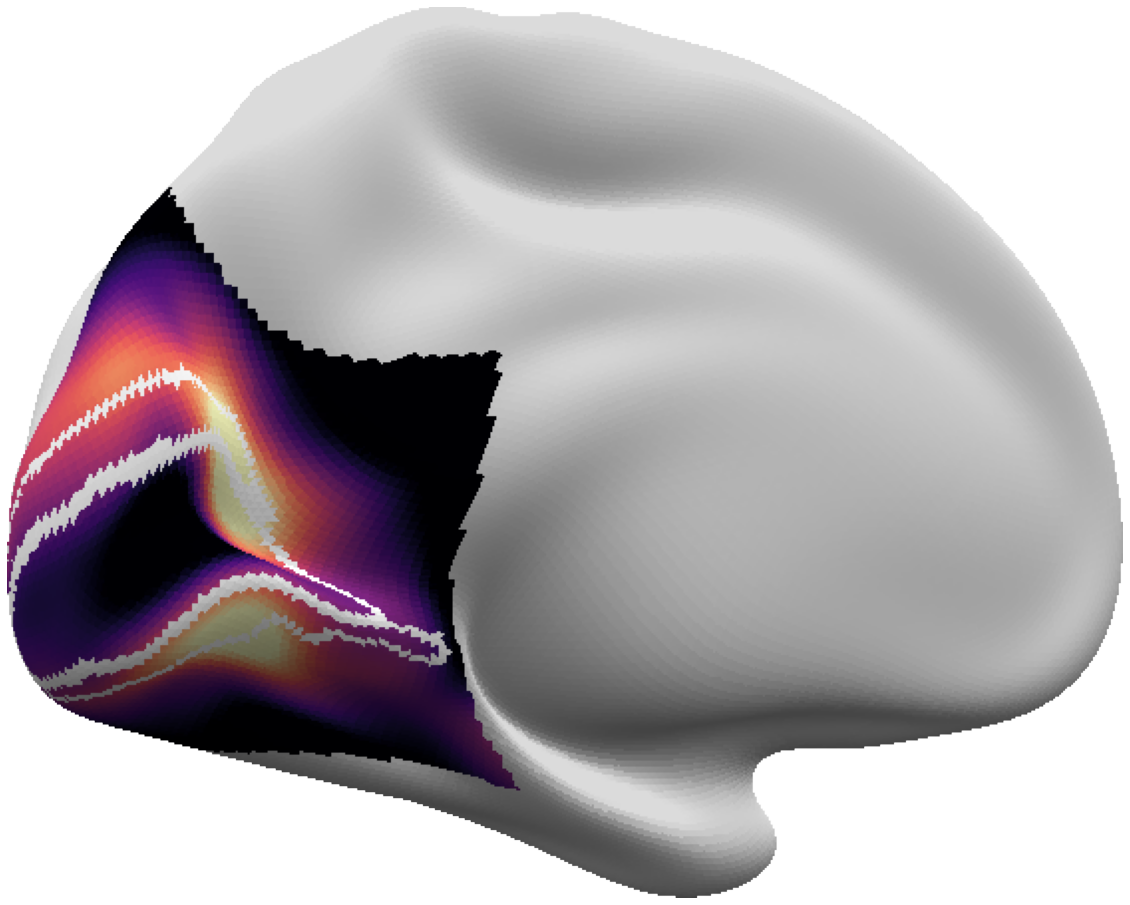

In [29]:

roi_pair = 'V1 V2'
roi_mask, restricted_parcels = get_rois_and_neighbours(roi_pairs[roi_pair][0],
                                                       roi_pairs[roi_pair][1],
                        inv_reg_dict,neighbours,parcellation)
flat_coords,new_faces,plot_mask = flatten(roi_mask)

r = R.from_euler('yz', [-10, -60], degrees=True)
spun=r.apply(surf.darrays[0].data)
gene_list = ['SYT6','TLE4','PCP4','PENK','OSTN', 'PHACTR2', 'KCNH8', 'ADAMTS17']
inds,_ = get_indices(gene_list)
m=np.mean(grad[inds],axis=0)

msp.plot_surf(spun,surf.darrays[1].data,
                  m,rotate=0,#z_rotate=30,
                      base_size=20,cmap='magma',colorbar=False,
              parcel=restricted_parcels,parcel_cmap={0:[1,1,1,1],1:[1,1,1,1],
                                                    2:[1,1,1,1],},
                  vmin=np.percentile(m[restricted_parcels>0],10),
              vmax=np.percentile(m[restricted_parcels>0],90),
              mask=~plot_mask>0,
                  filename= 'tmp.png'
                     )
plt.close('all')
subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
im_full=np.array(Image.open('tmp2.png').convert('RGBA'))

fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(im_full)
ax.axis('off')
fig.savefig('figures/v1_v2_inflated.pdf')


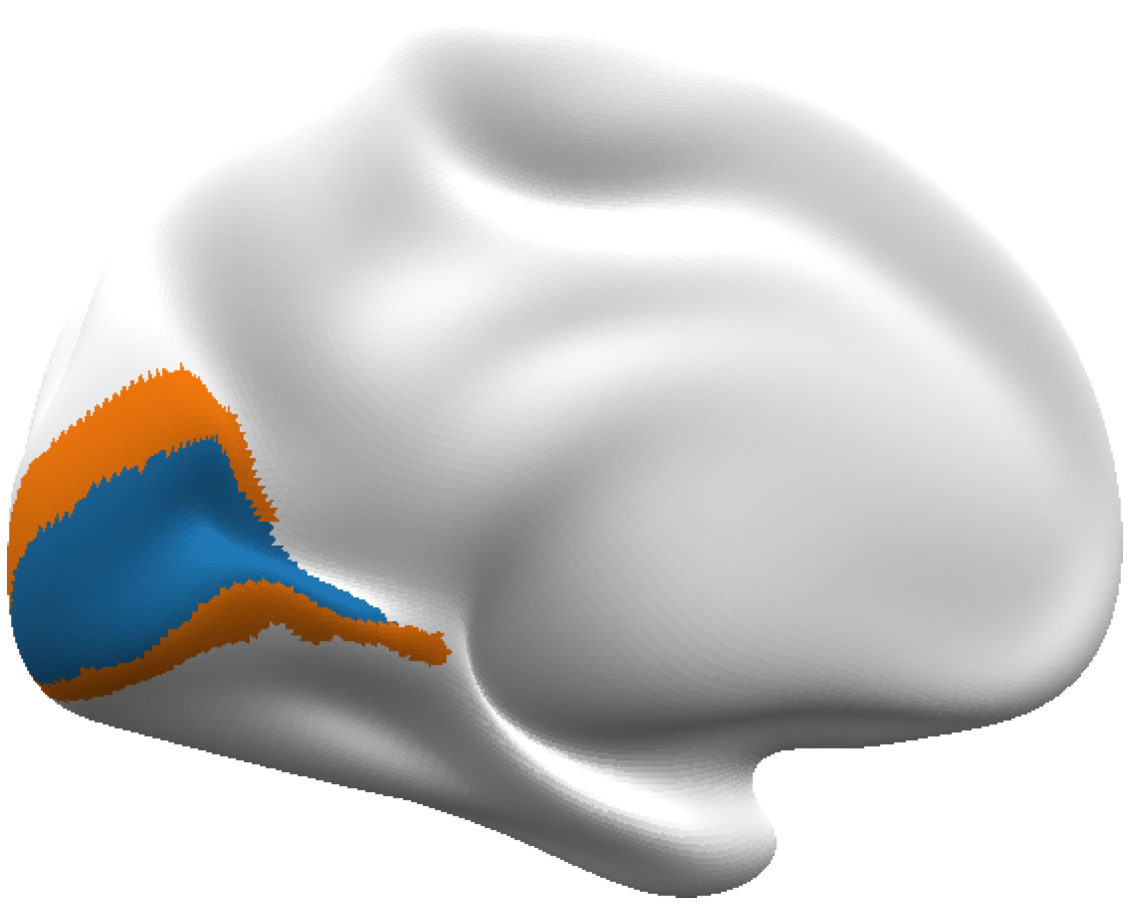

In [30]:
restricted_parcels_t = restricted_parcels+1
msp.plot_surf(spun,surf.darrays[1].data,
                  restricted_parcels_t,rotate=0,#z_rotate=30,
              label=False,
                      base_size=20,cmap='bwr',colorbar=False,
              parcel=restricted_parcels_t,
              parcel_cmap={0:[1,1,1,1],
                           1:[1,1,1,1],
                           2:[0.12156863, 0.46666667, 0.70588235,1],
                          3:[1.        , 0.49803922, 0.05490196,1]},
              filled_parcels=True,
                  
                  filename= 'tmp.png'
                     )

plt.close('all')
subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
im_full=np.array(Image.open('tmp2.png').convert('RGBA'))

fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(im_full)
ax.axis('off')
fig.savefig('figures/v1_v2_inflated_labels.pdf')

In [31]:
gene_lists = {'V1 V2\nHuman markers' :['SYT6','TLE4','PCP4','PENK'],
                  }

fig,axes = plt.subplots(4,2,figsize=(10,20))
for gl_i,glk in enumerate(gene_lists.keys()):
    print(gl_i)
    for g_i,gene in enumerate(gene_lists[glk]):
        print(gl_i,g_i)
        ind = get_indices([gene])[0][0]
        m=concat[ind]
        im_arr = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='turbo')
        axes[g_i,2*gl_i,].imshow(im_arr)
        axes[g_i,2*gl_i,].text(-90,im_arr.shape[1]/2,gene,rotation=90,
                              ha='center',va='center',fontsize=40)
        axes[g_i,2*gl_i,].axis('off')
        m=grad[ind]
        im_arr_grad = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='magma')
        axes[g_i,2*gl_i+1].imshow(im_arr_grad)
        axes[g_i,2*gl_i+1].axis('off')
        
axes[0,0].set_title('Expression\n',fontsize=40,va='center')
axes[0,1].set_title('Expression\ngradient',fontsize=40,va='center')
fig.savefig('figures/v1_v2_borders_human.pdf')




0
0 0
matching gene ids and names...
0 1
matching gene ids and names...
0 2
matching gene ids and names...
0 3
matching gene ids and names...


0
0 0
matching gene ids and names...
0 1
matching gene ids and names...
0 2
matching gene ids and names...
0 3
matching gene ids and names...


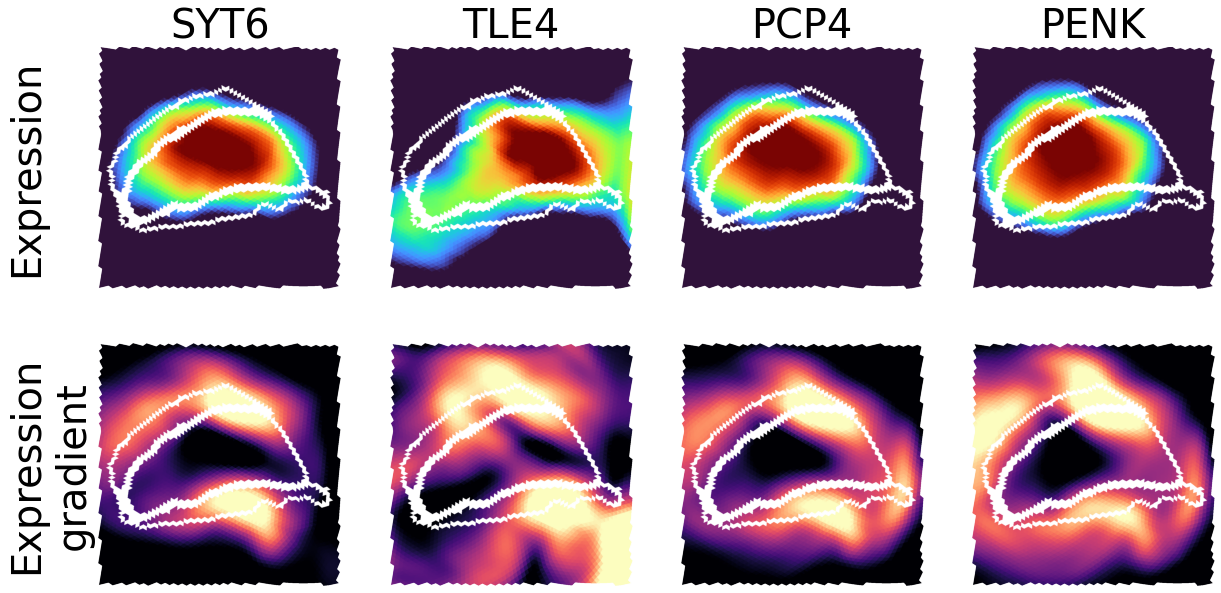

In [32]:
fig,axes = plt.subplots(2,4,figsize=(20,10))
for gl_i,glk in enumerate(gene_lists.keys()):
    print(gl_i)
    for g_i,gene in enumerate(gene_lists[glk]):
        print(gl_i,g_i)
        ind = get_indices([gene])[0][0]
        m=concat[ind]
        im_arr = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='turbo')
        axes[0,g_i,].imshow(im_arr)
        
        axes[0,g_i,].axis('off')
        m=grad[ind]
        im_arr_grad = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='magma')
        axes[1, g_i,].imshow(im_arr_grad)
        axes[1, g_i,].axis('off')
        axes[0, g_i].set_title(gene,fontsize=40)
        
#         text(-90,im_arr.shape[1]/2,gene,rotation=90,
#                               ha='center',va='center',fontsize=40)
        

axes[0,0].text(-220,im_arr.shape[1]/2,'Expression\n',rotation=90,
                              ha='center',va='center',fontsize=40)  
axes[1,0].text(-220,im_arr.shape[1]/2,'Expression\ngradient',rotation=90,
                              ha='center',va='center',fontsize=40)  

# axes[0,0].set_title('Expression\n',fontsize=40,va='center')
# axes[0,1].set_title('Expression\ngradient',fontsize=40,va='center')

fig.savefig('figures/v1_v2_borders_human_landscape.pdf')
fig

0 0
matching gene ids and names...
0 1
matching gene ids and names...
0 2
matching gene ids and names...
0 3
matching gene ids and names...
1 0
matching gene ids and names...
1 1
matching gene ids and names...
1 2
matching gene ids and names...
1 3
matching gene ids and names...


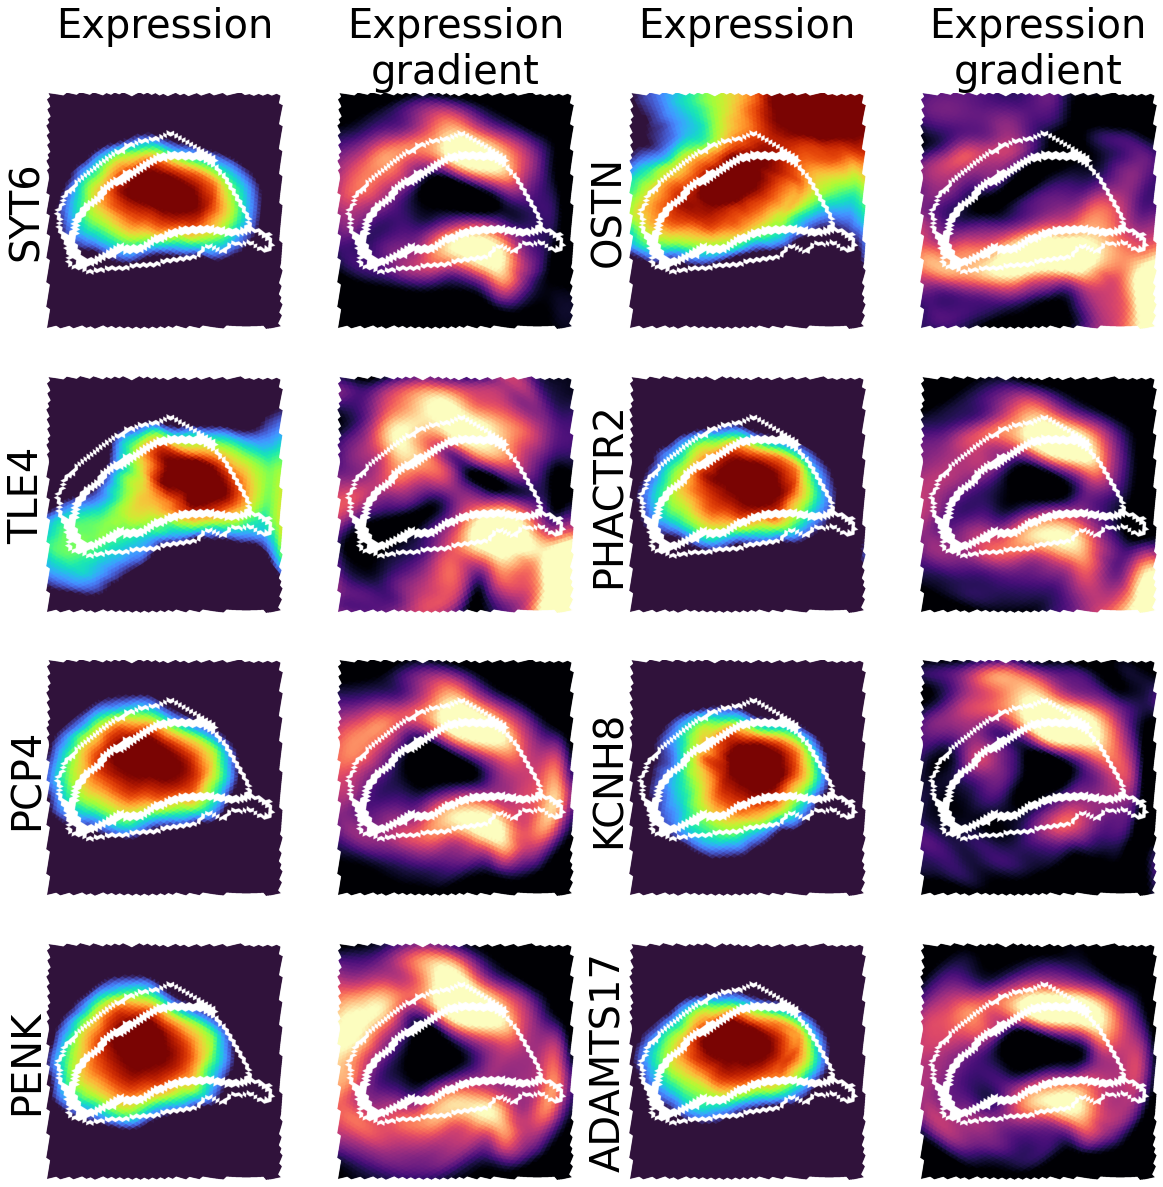

In [33]:
gene_lists = {'V1 V2\nHuman markers' :['SYT6','TLE4','PCP4','PENK'],
                  'V1 V2\nMacaque markers' : ['OSTN', 'PHACTR2', 'KCNH8', 'ADAMTS17']}

fig,axes = plt.subplots(4,4,figsize=(20,20))
for gl_i,glk in enumerate(gene_lists.keys()):
    for g_i,gene in enumerate(gene_lists[glk]):
        print(gl_i,g_i)
        ind = get_indices([gene])[0][0]
        m=concat[ind]
        im_arr = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='turbo')
        axes[g_i,2*gl_i,].imshow(im_arr)
        axes[g_i,2*gl_i,].text(-90,im_arr.shape[1]/2,gene,rotation=90,
                              ha='center',va='center',fontsize=40)
        axes[g_i,2*gl_i,].axis('off')
        m=grad[ind]
        im_arr_grad = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
             cmap='magma')
        axes[g_i,2*gl_i+1].imshow(im_arr_grad)
        axes[g_i,2*gl_i+1].axis('off')
        
axes[0,0].set_title('Expression\n',fontsize=40,va='center')
axes[0,1].set_title('Expression\ngradient',fontsize=40,va='center')
axes[0,2].set_title('Expression\n',fontsize=40,va='center')
axes[0,3].set_title('Expression\ngradient',fontsize=40,va='center')
fig.savefig('figures/v1_v2_borders.pdf')
fig

matching gene ids and names...
[0.01847758 0.03168859 0.01878063 ... 0.02258914 0.02369377 0.02191304]


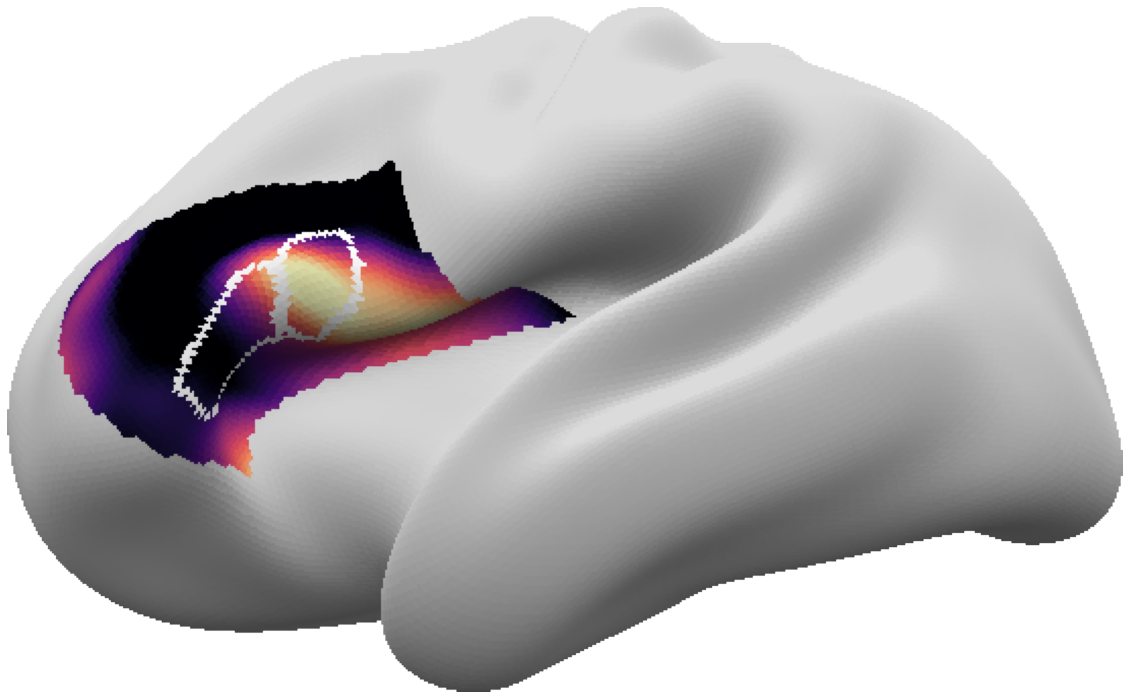

In [49]:
roi_pair = '44 45'
roi_mask, restricted_parcels = get_rois_and_neighbours(roi_pairs[roi_pair][0],
                                                       roi_pairs[roi_pair][1],
                        inv_reg_dict,neighbours,parcellation)
flat_coords,new_faces,plot_mask = flatten(roi_mask,d=np.pi/7)

#r = R.from_euler('y', [-270, ], degrees=True)
#spun=r.apply(surf.darrays[0].data)
gene_lists = ['SCN1B', 'KCNS1', 'TRIM55', 'RING1']
#gene_lists = ['TRIM55'] 

inds,_ = get_indices(gene_lists)
m=np.mean(grad[inds],axis=0)
print(m)
surf=nb.load(os.path.join(p.fs_LR32k_dir,'fs_LR.32k.L.inflated.surf.gii'))
r = R.from_euler('yx', [30,0 ], degrees=True)
spun=r.apply(surf.darrays[0].data)

msp.plot_surf(spun,surf.darrays[1].data,
                  m,rotate=100,#z_rotate=30,
                      base_size=20,cmap='magma',colorbar=False,
              parcel=restricted_parcels,parcel_cmap={0:[1,1,1,1],1:[1,1,1,1],
                                                    2:[1,1,1,1],},
                  vmin=np.percentile(m[restricted_parcels>0],10),
              vmax=np.percentile(m[restricted_parcels>0],90),
              mask=~plot_mask>0,
                  filename= 'tmp.png'
                     )
plt.close('all')
subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
im_full=np.array(Image.open('tmp2.png').convert('RGBA'))

fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(im_full)
ax.axis('off')
fig.savefig('figures/44_45_inflated.pdf')



In [ ]:


surf=nb.load(os.path.join(p.fs_LR32k_dir,'fs_LR.32k.L.pial.surf.gii'))


restricted_parcels_t = restricted_parcels+1
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
                  restricted_parcels_t,rotate=100,#z_rotate=30,
              label=False,
                      base_size=20,cmap='bwr',colorbar=False,
              parcel=restricted_parcels_t,
              parcel_cmap={0:[1,1,1,1],
                           1:[1,1,1,1],
                           2:[0.7372549 , 0.74117647, 0.13333333,1],
                          3:[0.09019608, 0.74509804, 0.81176471,1]},
              filled_parcels=True,
                  
                  filename= 'tmp.png'
                     )

plt.close('all')
subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
im_full=np.array(Image.open('tmp2.png').convert('RGBA'))

fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(im_full)
ax.axis('off')
fig.savefig('figures/44_45_pial_parcels.pdf')

matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...


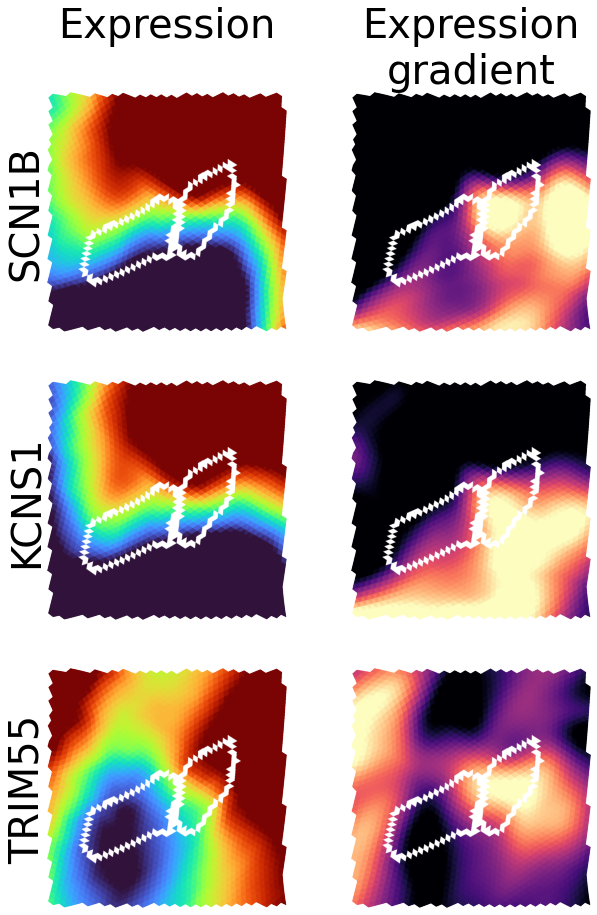

In [27]:
gene_lists = {'44 45b\nMacaque markers' :['SCN1B', 'KCNS1', 'TRIM55', 'RING1'],}

fig,axes = plt.subplots(3,2,figsize=(10,15))
k=-1
for gl_i,glk in enumerate(gene_lists.keys()):
    for g_i,gene in enumerate(gene_lists[glk]):
        try:
            ind = get_indices([gene])[0][0]
            k+=1
            m=concat[ind]
            im_arr = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
                 cmap='turbo')
            axes[k,2*gl_i,].imshow(im_arr)
            axes[k,2*gl_i,].axis('off')
            axes[g_i,2*gl_i,].text(-90,im_arr.shape[1]/2,
                                   gene,rotation=90,
                              ha='center',va='center',
                                   fontsize=40)
            m=grad[ind]
            im_arr_grad = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
                 cmap='magma')
            axes[k,2*gl_i+1].imshow(im_arr_grad)
            axes[k,2*gl_i+1].axis('off')
        except ValueError:
            pass
axes[0,0].set_title('Expression\n',fontsize=40,va='center')
axes[0,1].set_title('Expression\ngradient',fontsize=40,va='center')
fig.savefig('figures/44_45_borders.pdf')
fig

matching gene ids and names...
[0.01318772 0.04031958 0.01743367 ... 0.01363086 0.0138537  0.0131161 ]


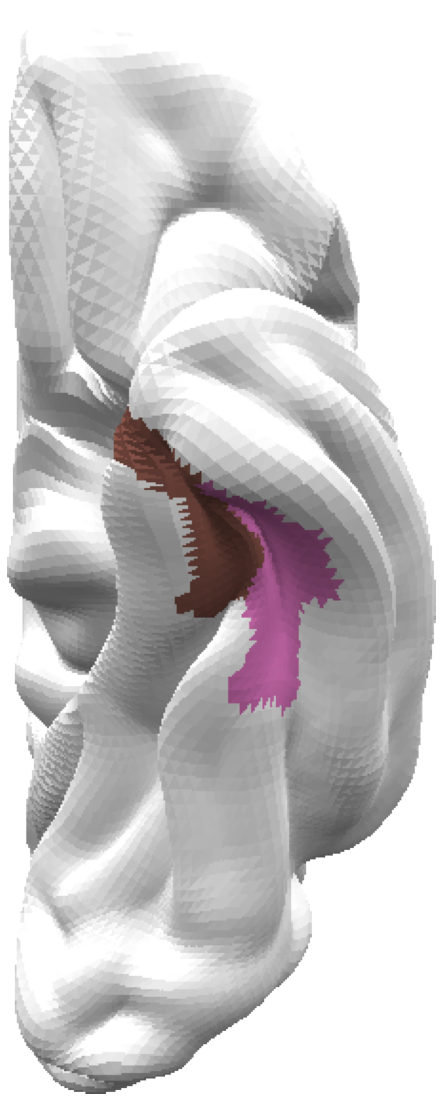

In [29]:
roi_mask, restricted_parcels = get_rois_and_neighbours('L_PeEc_ROI','L_TF_ROI',
                        inv_reg_dict,neighbours,parcellation)

flat_coords,new_faces,plot_mask = flatten(roi_mask,d=np.pi/7,rotate_extra=130)


gene_lists = ['HTR2A', 'NGB', 'CHRNA3', 'NTS']

inds,_ = get_indices(gene_lists)
m=np.mean(grad[inds],axis=0)
print(m)
surf=nb.load(os.path.join(p.fs_LR32k_dir,'fs_LR.32k.L.inflated.surf.gii'))
r = R.from_euler('yx', [270,90 ], degrees=True)
spun=r.apply(surf.darrays[0].data)

msp.plot_surf(spun,surf.darrays[1].data,
                  m,rotate=270,#z_rotate=90,
                      base_size=20,cmap='magma',colorbar=False,
              parcel=restricted_parcels,parcel_cmap={0:[1,1,1,1],1:[1,1,1,1],
                                                    2:[1,1,1,1],},
                  vmin=np.percentile(m[restricted_parcels>0],10),
              vmax=np.percentile(m[restricted_parcels>0],90),
               mask=np.logical_or(~(plot_mask>0),~cortex),
                  filename= 'tmp.png'
                     )

plt.close('all')
subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
im_full=np.array(Image.open('tmp2.png').convert('RGBA'))

fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(im_full)
ax.axis('off')
fig.savefig('figures/PeEc_TF_inflated.pdf')


surf=nb.load(os.path.join(p.fs_LR32k_dir,'fs_LR.32k.L.pial.surf.gii'))
r = R.from_euler('yx', [270,90 ], degrees=True)
spun=r.apply(surf.darrays[0].data)

restricted_parcels_t = restricted_parcels+1
msp.plot_surf(spun,surf.darrays[1].data,
                  restricted_parcels_t,rotate=270,#z_rotate=30,
              label=False,
                      base_size=20,cmap='bwr',colorbar=False,
              parcel=restricted_parcels_t,
              parcel_cmap={0:[1,1,1,1],
                           1:[1,1,1,1],
                           2:[0.5490196078431373, 0.33725490196078434,
                              0.29411764705882354,1],
                          3:[0.8901960784313725, 0.4666666666666667, 0.7607843137254902,1]},
              filled_parcels=True,
                  
                  filename= 'tmp.png'
                     )

plt.close('all')
subprocess.call('convert tmp.png -trim tmp2.png',shell=True)
im_full=np.array(Image.open('tmp2.png').convert('RGBA'))

fig,ax = plt.subplots(1,figsize=(20,20))
ax.imshow(im_full)
ax.axis('off')
fig.savefig('figures/PeEc_TF_pial_parcels.pdf')


matching gene ids and names...
matching gene ids and names...
matching gene ids and names...
matching gene ids and names...


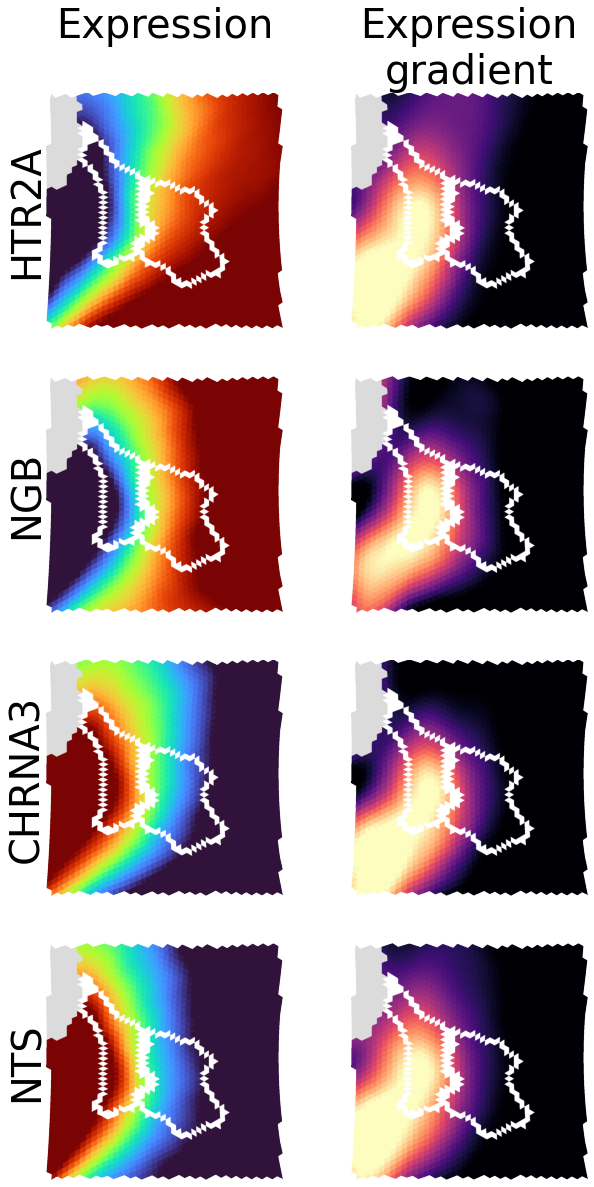

In [69]:
gene_lists = {'mTL' : ['HTR2A', 'NGB', 'CHRNA3', 'NTS'],}

fig,axes = plt.subplots(4,2,figsize=(10,20))
k=-1
for gl_i,glk in enumerate(gene_lists.keys()):
    for g_i,gene in enumerate(gene_lists[glk]):
        try:
            ind = get_indices([gene])[0][0]
            k+=1
            m=concat[ind]
            im_arr = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
                 cmap='turbo',mask=~cortex)
            axes[k,2*gl_i,].imshow(im_arr)
            axes[k,2*gl_i,].axis('off')
            axes[g_i,2*gl_i,].text(-90,im_arr.shape[1]/2,
                                   gene,rotation=90,
                              ha='center',va='center',
                                   fontsize=40)
            m=grad[ind]
            im_arr_grad = plot_flat(flat_coords,new_faces,m,restricted_parcels,neighbours,
                 cmap='magma',mask=~cortex)
            axes[k,2*gl_i+1].imshow(im_arr_grad)
            axes[k,2*gl_i+1].axis('off')
        except ValueError:
            pass
        
axes[0,0].set_title('Expression\n',fontsize=40,va='center')
axes[0,1].set_title('Expression\ngradient',fontsize=40,va='center')
fig.savefig('figures/PeEc_TF_borders.pdf')
fig

<AxesSubplot:xlabel='Gene list', ylabel='Gradient percentile %'>

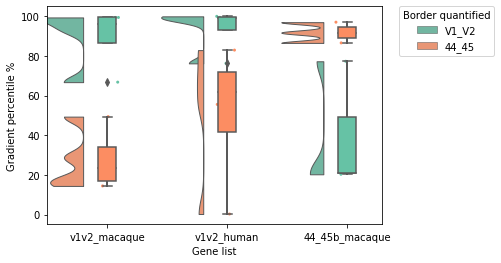

In [119]:
#check that the genes are specific to the border
plot_df = pd.DataFrame(np.vstack([rp,source,vals]).T,columns=['Border quantified','Gene list',
                                                'Gradient percentile %'])
plot_df['Gradient percentile %']=plot_df['Gradient percentile %'].astype(float)*100
pt.RainCloud(data = plot_df, x='Gene list',y='Gradient percentile %',hue='Border quantified',
            )

In [70]:
v1v2_tstats=ranked_ttest('L_V1_ROI','L_V2_ROI',
                         concat,parcellation,inv_reg_dict)
central_tstats=ranked_ttest('L_4_ROI','L_3a_ROI',
                         concat,parcellation,inv_reg_dict)
mtl_tstats=ranked_ttest('L_PeEc_ROI','L_TF_ROI',
                         concat,parcellation,inv_reg_dict)

In [74]:
predictability = np.mean(stored_corrs[:,number_subs==3],axis=1)
border_stats = grad[:,v1v2_border].mean(axis=1)
region_stats = np.abs(v1v2_tstats)
ranks=[]
gene_names=np.loadtxt('weighted_island_vectors/gene_names.txt',dtype=str)
ranked_genes = gene_names[np.abs(v1v2_tstats).argsort()]
df = pd.DataFrame(np.vstack([gene_names,region_stats,
                             border_stats,predictability]).T,columns = ['Genes','Ttest','Border','Predictability'])


In [25]:
predictability = np.mean(stored_corrs[:,number_subs==3],axis=1)
border_stats = grad[:,central_sulc_border].mean(axis=1)
region_stats = np.abs(central_tstats)
ranks=[]
gene_names=np.loadtxt('weighted_island_vectors/gene_names.txt',dtype=str)
ranked_genes = gene_names[np.abs(central_tstats).argsort()]
df = pd.DataFrame(np.vstack([gene_names,region_stats,
                             border_stats,predictability]).T,columns = ['Genes','Ttest','Border','Predictability'])


In [46]:
border_stats = grad[:,mtl_border].mean(axis=1)
region_stats = np.abs(mtl_tstats)
ranks=[]
gene_names=np.loadtxt('weighted_island_vectors/gene_names.txt',dtype=str)
ranked_genes = gene_names[np.abs(mtl_tstats).argsort()]
df = pd.DataFrame(np.vstack([gene_names,region_stats,
                             border_stats,predictability]).T,columns = ['Genes','Ttest','Border','Predictability'])
df

Genes      Ttest       Border          Predictability
0      A_24_P614148  19.662989  0.008951654      0.6086575685119561
1              A1BG  2.8875618  0.011162385      0.6024981712920922
2              A1CF   28.78285  0.037758768  -0.0020223395754539247
3               A2M  26.920527  0.044413794     0.03604495720343257
4             A2ML1   8.787901    0.0129703    0.023971802756833464
...             ...        ...          ...                     ...
20776        ZYG11A  1.5724797  0.025962152    -0.03597183694038993
20777        ZYG11B  4.7212725  0.007355592     0.08320933673898874
20778           ZYX   34.99074   0.04233633      0.9489708501432211
20779         ZZEF1   2.150219  0.010311916     0.38484018265765296
20780          ZZZ3  24.820992  0.015093785      0.3083833192932936

[20781 rows x 4 columns]

matching gene ids and names...
OSTN       Genes     Ttest       Border      Predictability  Combined_rank  \
13041  OSTN  17.98789  0.011232796  0.7837935699104043        0.07798   

       Ttest_rank  Border_rank  
13041    0.409268      0.14417  
matching gene ids and names...
PHACTR2          Genes      Ttest       Border      Predictability  Combined_rank  \
13594  PHACTR2  29.861675  0.021472875  0.6769821419422367       0.297339   

       Ttest_rank  Border_rank  
13594    0.607574     0.493865  
matching gene ids and names...
KCNH8       Genes      Ttest       Border       Predictability  Combined_rank  \
8419  KCNH8  24.250032  0.012331498  0.35874394462312575       0.141644   

      Ttest_rank  Border_rank  
8419    0.574323      0.17848  
matching gene ids and names...
ADAMTS17         Genes      Ttest        Border      Predictability  Combined_rank  \
280  ADAMTS17  29.251818  0.0155147165  0.5176027408047695       0.198571   

     Ttest_rank  Border_rank  
280    0.6054

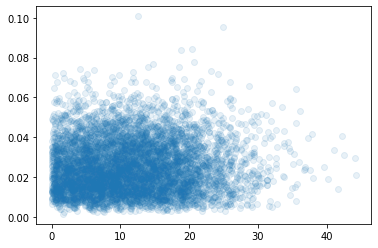

In [77]:
t=0.5
m=predictability>t

plt.scatter(df['Ttest'].astype(float)[m],df['Border'].astype(float)[m],alpha=0.1,
            )
np.corrcoef(df['Ttest'].astype(float)[m],df['Border'].astype(float)[m])

df['Genes'][m].values[np.argsort(df['Ttest'][m].argsort().argsort()+df['Border'][m].argsort().argsort())][-40:]

# ish_genes=np.loadtxt('ish_gene_lists/ish_genes.txt',dtype=str)
# filtered = []
# for g in df['Genes'][m].values[np.argsort(df['Ttest'][m].argsort().argsort()+df['Border'][m].argsort().argsort())]:
#     if g in ish_genes:
#         filtered.append(g)
# filtered
#df = df[m]
df['Combined_rank'] = ((df['Ttest'].argsort().argsort()+df['Border'].argsort().argsort()).argsort().argsort())/(2*len(df))
df['Ttest_rank'] = df['Ttest'].argsort().argsort()/len(df)
df['Border_rank'] = df['Border'].argsort().argsort()/len(df)

for g in ['OSTN', 'PHACTR2', 'KCNH8', 'ADAMTS17']:
    gene_i,_=get_indices([g])
    print(g,df.loc[gene_i])
    
for g in ['SCN1B', 'KCNS1', 'TRIM55', 'RING1']:
    try:
        gene_i,_=get_indices([g])
        print(g,df.loc[gene_i])
    except ValueError:
        pass


matching gene ids and names...


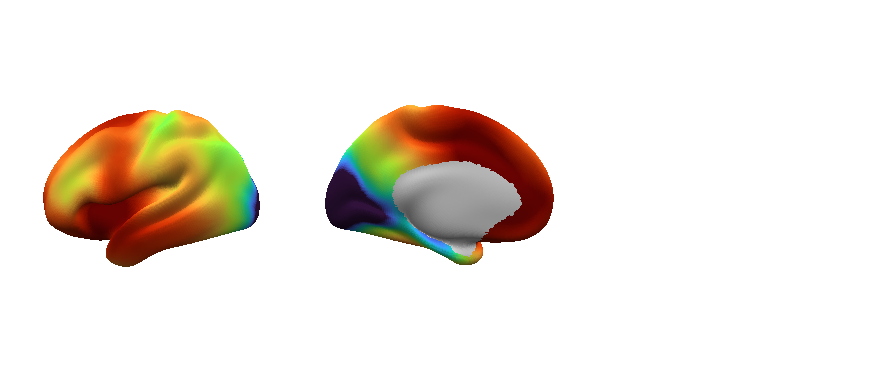

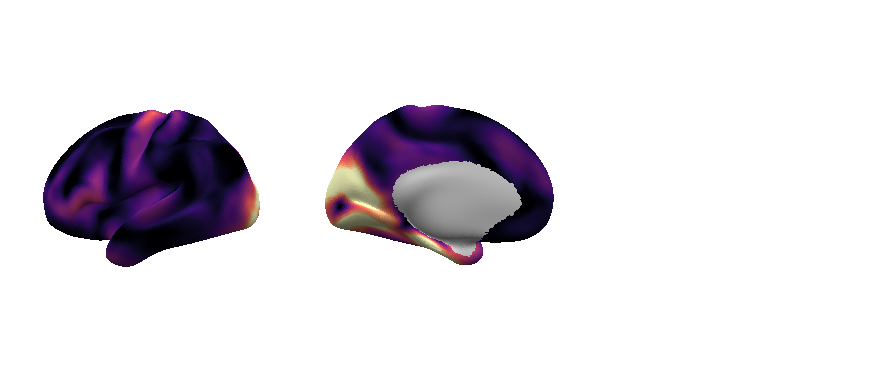

In [23]:
gene_i,m=get_indices(['ADRA1B'])
m=concat[gene_i[0]]
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
              m,cmap='turbo',colorbar=False,mask=~cortex,vmax=np.percentile(m,95),
              vmin=np.percentile(m,5),
                 )
m=grad[gene_i[0]]
msp.plot_surf(surf.darrays[0].data,surf.darrays[1].data,
              m,cmap='magma',colorbar=False,mask=~cortex,vmax=np.percentile(m,95),
              vmin=np.percentile(m,5),
                 )

In [59]:
grad=np.load(os.path.join(base_dir,'all_subs_gradients.npy'))


In [95]:
border_stats = grad[:,v1v2_border].mean(axis=1)
border_ranks=[]
for g in ['SYT6','SCN3B','TLE4']:
    gene_i,m=get_indices([g])
    border_ranks.append(np.abs(border_stats).argsort().argsort()[gene_i[0]])
    
border_ranks

matching gene ids and names...
matching gene ids and names...
matching gene ids and names...


[20777, 20336, 15848]

In [97]:
border_stats = grad[:,central_sulc_border].mean(axis=1)
border_ranks=[]
for g in ['SYT6','SCN3B','TLE4']:
    gene_i,m=get_indices([g])
    border_ranks.append(np.abs(border_stats).argsort().argsort()[gene_i[0]])


matching gene ids and names...
matching gene ids and names...
matching gene ids and names...


In [11]:
spins = np.load("spin_dir/spins_10000.npy")

In [14]:
grad_c = grad[:,cortex]

In [64]:
border = get_boundary('L_4_ROI','L_3a_ROI',neighbours,parcellation,inv_reg_dict)


In [65]:
mask = np.zeros(sum(cortex),dtype=bool)
mask[border] = True

In [66]:
genes_grads=np.mean(grad_c[:,mask],axis=1)
g=np.median(genes_grads)

In [67]:
n_spins=1000
permed=np.zeros((n_spins,grad.shape[0]))
permed2=np.zeros(n_spins)
for s in np.arange(n_spins):
    spun_mask = mask[spins[s]]
    permed[s] = np.mean(grad_c[:,spun_mask],axis=1)
    permed2[s] = np.median(permed[s])